In [1]:
# Week 7 — Track 1: Stable Diffusion (txt2img, img2img, inpaint, tiny LoRA, FastAPI endpoint)
# End-to-end notebook for Colab T4 (CUDA 12.1). No feature toggles.

# 0) Clean installs (pin to a working stack)
!pip -q uninstall -y xformers torchaudio -q
!pip -q install --upgrade pip
!pip -q install torch==2.3.1+cu121 torchvision==0.18.1+cu121 --index-url https://download.pytorch.org/whl/cu121
!pip -q install diffusers==0.29.2 transformers==4.41.2 accelerate==0.30.1 safetensors==0.4.3 peft==0.10.0 pillow==10.4.0 fastapi==0.110.0 uvicorn==0.30.6 pyngrok==7.2.3
!pip -q install torchaudio==2.3.1+cu121 --index-url https://download.pytorch.org/whl/cu121

# Cloudflare tunnel binary (no login needed)
!wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64 -O /usr/local/bin/cloudflared
!chmod +x /usr/local/bin/cloudflared


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 32.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.14.1 requires fastapi<1.0.0,>=0.115.0, but you have fastapi 0.110.0 which is incompatible.
google-adk 1.14.1 requires starlette<1.0.0,>=0.46.2, but you have starlette 0.36.3 which is incompatible.
google-adk 1.14.1 requires uvicorn<1.0.0,>=0.34.0, but you have uvicorn 0.30.6 which is incompatible.
gradio 5.49.0 requires fastapi<1.0,>=0.115.2, but you have fastapi 0.110.0 which is incompatible.
gradio 5.49.0 requires starlette<1.0,>=0.40.0, but you have starlette 0.36.3 which is incompatible.
mcp 1.16.0 requires uvicorn>=0.31.1; sys_platform != "emscripten", but you have uvicorn 0.30.6 which is incompatible.


In [2]:
# 1) Verify environment
import torch, diffusers, transformers
print("torch:", torch.__version__)
print("torchvision:", __import__("torchvision").__version__)
print("torchaudio:", __import__("torchaudio").__version__)
print("CUDA available:", torch.cuda.is_available())
print("diffusers:", diffusers.__version__)
print("transformers:", transformers.__version__)


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

torch: 2.3.1+cu121
torchvision: 0.18.1+cu121
torchaudio: 2.3.1+cu121
CUDA available: True
diffusers: 0.29.2
transformers: 4.41.2


In [3]:
# 2) Setup paths/utilities
import os, json, time, gc, random, subprocess
from pathlib import Path
from PIL import Image, ImageDraw
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype  = torch.float16 if device == "cuda" else torch.float32

BASE_DIR   = Path("/content")
OUT_DIR    = BASE_DIR / "outputs_sd"
LORA_DATA  = BASE_DIR / "lora_data"
LORA_OUT   = BASE_DIR / "lora_weights"
LOG_DIR    = BASE_DIR / "logs"
for p in [OUT_DIR, LORA_DATA, LORA_OUT, LOG_DIR]:
    p.mkdir(parents=True, exist_ok=True)

METRICS_PATH = OUT_DIR / "generation_metrics.json"

def save_pil(img: Image.Image, path: Path) -> str:
    img.save(str(path))
    return str(path)


In [4]:
# 3) Load Stable Diffusion pipelines (SD 1.5)
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, StableDiffusionInpaintPipeline

MODEL_ID = "runwayml/stable-diffusion-v1-5"

txt2img_pipe = StableDiffusionPipeline.from_pretrained(MODEL_ID, torch_dtype=dtype).to(device)
try: txt2img_pipe.enable_attention_slicing()
except: pass

img2img_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(MODEL_ID, torch_dtype=dtype).to(device)
inpaint_pipe = StableDiffusionInpaintPipeline.from_pretrained(MODEL_ID, torch_dtype=dtype).to(device)

print("Pipelines ready on", device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Pipelines ready on cuda


In [5]:
# 4) TXT2IMG — generate ≥3 academic-style images
prompts = [
    "academic-style schematic diagram of a multi-agent AI diplomacy system, agents negotiating on a map, clean vector infographic, minimal color palette",
    "flat vector infographic of a medical multi-agent decision framework with moderator, recruiter, MDT, ICT, arrows and labeled roles, teal and gray theme",
    "conceptual flowchart of a multi-agent RAG pipeline with retrieval, planner, tool calls, and verification, minimalist journal figure"
]
negative_prompt = "low quality, blurry, nsfw, watermark, logo"

steps, guidance = 25, 7.5
height = width = 512
seeds = [42, 123, 2025]

generated_paths, runs = [], []
for i, p in enumerate(prompts):
    g = torch.Generator(device=device).manual_seed(seeds[i % len(seeds)])
    t0 = time.perf_counter()
    img = txt2img_pipe(
        prompt=p, negative_prompt=negative_prompt,
        num_inference_steps=steps, guidance_scale=guidance,
        height=height, width=width, generator=g
    ).images[0]
    dt = round(time.perf_counter() - t0, 3)
    path = OUT_DIR / f"txt2img_{i}.png"
    save_pil(img, path); generated_paths.append(str(path))
    runs.append({"type":"txt2img","prompt":p,"seed":int(seeds[i%len(seeds)]),"latency_s":dt,"path":str(path)})

metrics = {
    "model_id": MODEL_ID, "device": device,
    "height": height, "width": width,
    "num_inference_steps": steps, "guidance_scale": guidance,
    "runs": runs
}
METRICS_PATH.write_text(json.dumps(metrics, indent=2))
generated_paths


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

['/content/outputs_sd/txt2img_0.png',
 '/content/outputs_sd/txt2img_1.png',
 '/content/outputs_sd/txt2img_2.png']

In [6]:
# 5) IMG2IMG — perform one required edit
init_img_path = generated_paths[0]
init_image = Image.open(init_img_path).convert("RGB").resize((width, height))

edit_prompt = "convert the academic diagram into a night-mode neon accent poster, high legibility, clean labels"

t0 = time.perf_counter()
edited = img2img_pipe(
    prompt=edit_prompt, image=init_image,
    strength=0.6, guidance_scale=8.0, num_inference_steps=30
).images[0]
dt = round(time.perf_counter() - t0, 3)
edited_path = OUT_DIR / "img2img_edit.png"
save_pil(edited, edited_path)

m = json.loads(METRICS_PATH.read_text())
m["runs"].append({"type":"img2img","prompt":edit_prompt,"seed":None,"latency_s":dt,"path":str(edited_path),"init_image":init_img_path})
METRICS_PATH.write_text(json.dumps(m, indent=2))
str(edited_path)


  0%|          | 0/18 [00:00<?, ?it/s]

'/content/outputs_sd/img2img_edit.png'

In [7]:
# 6) INPAINT — upload one base figure; auto-build a mask and inpaint
from google.colab import files

print("Select your base figure (PNG/JPG).")
up = files.upload()
base_uploaded = list(up.keys())[0]
BASE_IMG = BASE_DIR / "base.png"
os.rename(base_uploaded, BASE_IMG)

# build mask: top title band + a likely legend rectangle (left plot zone guess)
base = Image.open(BASE_IMG).convert("RGB")
W, H = base.size
mask = Image.new("L", (W, H), color=0)
d = ImageDraw.Draw(mask)

# title bar region
d.rectangle([0, 0, W, int(0.15*H)], fill=255)
# legend region guess in left third
d.rectangle([int(0.18*W), int(0.68*H), int(0.42*W), int(0.82*H)], fill=255)

MASK_IMG = BASE_DIR / "mask.png"
mask.save(MASK_IMG)

inpaint_prompt = (
    "replace the title with 'Impact of Agent Count and Temperature on Accuracy', "
    "clean journal typography; add a clear legend with labels Ours (green), Solo (red dashed), "
    "Group (blue dashed), journal figure style"
)

base_resized = base.resize((width, height))
mask_resized = mask.resize((width, height))

t0 = time.perf_counter()
inpainted = inpaint_pipe(
    prompt=inpaint_prompt,
    image=base_resized, mask_image=mask_resized,
    guidance_scale=guidance, num_inference_steps=steps
).images[0]
dt = round(time.perf_counter() - t0, 3)
inpaint_path = OUT_DIR / "inpaint_edit.png"
save_pil(inpainted, inpaint_path)

m = json.loads(METRICS_PATH.read_text())
m["runs"].append({
    "type":"inpaint","prompt":inpaint_prompt,"seed":None,"latency_s":dt,
    "path":str(inpaint_path),"base_image":str(BASE_IMG),"mask_image":str(MASK_IMG)
})
METRICS_PATH.write_text(json.dumps(m, indent=2))

print("Saved base:", BASE_IMG)
print("Saved mask:", MASK_IMG)
print("Saved inpaint:", inpaint_path)


Select your base figure (PNG/JPG).


Saving ablation2.png to ablation2.png


  0%|          | 0/25 [00:00<?, ?it/s]

Saved base: /content/base.png
Saved mask: /content/mask.png
Saved inpaint: /content/outputs_sd/inpaint_edit.png


In [8]:
# 7) Tiny LoRA — low-VRAM DreamBooth LoRA (rank=2, 30 steps @ 384px), then 2 gens

# Free VRAM first
try:
    del txt2img_pipe, img2img_pipe, inpaint_pipe
except NameError:
    pass
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Tiny synthetic dataset (12 imgs) if missing
if not any(LORA_DATA.glob("*.png")):
    for i in range(12):
        im = Image.new("RGB", (512,512), "white")
        drw = ImageDraw.Draw(im)
        for x in range(0,512,64): drw.line([(x,0),(x,512)], fill=(200,200,200), width=1)
        for y in range(0,512,64): drw.line([(0,y),(512,y)], fill=(200,200,200), width=1)
        nodes = [(random.randint(80,432), random.randint(80,432)) for _ in range(7)]
        for x,y in nodes: drw.ellipse([x-10,y-10,x+10,y+10], outline="black", width=3)
        for _ in range(6):
            a,b = random.sample(nodes,2)
            drw.line([a,b], fill="black", width=3)
        drw.text((16,16), f"synthetic-figure-{i}", fill=(0,0,0))
        im.save(LORA_DATA / f"img_{i:02d}.png")

# Fetch version-matched trainer
!curl -sS -L https://raw.githubusercontent.com/huggingface/diffusers/v0.29.2/examples/dreambooth/train_dreambooth_lora.py -o train_dreambooth_lora.py

MODEL_ID = "runwayml/stable-diffusion-v1-5"
INSTANCE_PROMPT = "diagram of interconnected nodes and arrows, academic style, monochrome"

# Low-VRAM training
!accelerate launch train_dreambooth_lora.py \
  --pretrained_model_name_or_path={MODEL_ID} \
  --instance_data_dir={str(LORA_DATA)} \
  --instance_prompt="{INSTANCE_PROMPT}" \
  --output_dir={str(LORA_OUT)} \
  --logging_dir={str(LOG_DIR)} \
  --resolution=384 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-4 \
  --lr_warmup_steps=0 \
  --max_train_steps=30 \
  --mixed_precision=fp16 \
  --gradient_checkpointing \
  --rank=2 \
  --checkpointing_steps=0

# Apply LoRA and make 2 outputs
from diffusers import StableDiffusionPipeline
pipe_lora = StableDiffusionPipeline.from_pretrained(MODEL_ID, torch_dtype=dtype).to(device)
pipe_lora.load_lora_weights(str(LORA_OUT))

lora_prompts = [
    "academic diagram with interconnected nodes and labeled arrows, clean lines, monochrome",
    "minimalist infographic of multi-agent collaboration with callout boxes and arrows, journal style"
]
lora_paths = []
for i, p in enumerate(lora_prompts):
    g = torch.Generator(device=device).manual_seed(777+i)
    img = pipe_lora(
        prompt=p, negative_prompt="nsfw, blurry, watermark, logo",
        num_inference_steps=25, guidance_scale=7.5,
        height=512, width=512, generator=g
    ).images[0]
    fp = OUT_DIR / f"lora_out_{i}.png"
    img.save(fp); lora_paths.append(str(fp))

# Append to metrics
m = json.loads(METRICS_PATH.read_text())
for i, p in enumerate(lora_prompts):
    m["runs"].append({"type":"txt2img_lora","prompt":p,"path":lora_paths[i],"seed":777+i,"latency_s":None})
METRICS_PATH.write_text(json.dumps(m, indent=2))

lora_paths


The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2025-10-14 01:42:44.749948: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760406164.775876    2881 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760406164.783967    2881 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760406164.818053    2881 computation_plac

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

OSError: Error no file named pytorch_lora_weights.bin found in directory /content/lora_weights.

In [9]:
# ✅ Tiny LoRA (stable for diffusers==0.29.2) — low VRAM, no modulo-by-zero, auto-load weights, write metrics

import os, gc, json, random, time, glob
from pathlib import Path
from PIL import Image, ImageDraw
import torch

# -------- Free VRAM from earlier pipelines --------
for var in ["txt2img_pipe", "img2img_pipe", "inpaint_pipe"]:
    if var in globals():
        try: del globals()[var]
        except: pass
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# -------- Paths --------
BASE_DIR   = Path("/content")
OUT_DIR    = BASE_DIR / "outputs_sd"; OUT_DIR.mkdir(parents=True, exist_ok=True)
LORA_DATA  = BASE_DIR / "lora_data";  LORA_DATA.mkdir(parents=True, exist_ok=True)
LORA_OUT   = BASE_DIR / "lora_weights"; LORA_OUT.mkdir(parents=True, exist_ok=True)
LOG_DIR    = BASE_DIR / "logs"; LOG_DIR.mkdir(parents=True, exist_ok=True)
METRICS    = OUT_DIR / "generation_metrics.json"
MODEL_ID   = "runwayml/stable-diffusion-v1-5"

# -------- Tiny synthetic dataset (12 imgs) if missing --------
if not any(LORA_DATA.glob("*.png")):
    for i in range(12):
        img = Image.new("RGB", (512,512), "white")
        drw = ImageDraw.Draw(img)
        for x in range(0,512,64): drw.line([(x,0),(x,512)], fill=(200,200,200), width=1)
        for y in range(0,512,64): drw.line([(0,y),(512,y)], fill=(200,200,200), width=1)
        nodes = [(random.randint(80,432), random.randint(80,432)) for _ in range(7)]
        for x,y in nodes: drw.ellipse([x-10,y-10,x+10,y+10], outline="black", width=3)
        for _ in range(6):
            a,b = random.sample(nodes,2)
            drw.line([a,b], fill="black", width=3)
        drw.text((16,16), f"synthetic-figure-{i}", fill=(0,0,0))
        img.save(LORA_DATA / f"img_{i:02d}.png")

# -------- Get version-matched trainer (diffusers v0.29.2) --------
!curl -sS -L https://raw.githubusercontent.com/huggingface/diffusers/v0.29.2/examples/dreambooth/train_dreambooth_lora.py -o train_dreambooth_lora.py

# -------- Train LoRA (low VRAM) --------
INSTANCE_PROMPT = "diagram of interconnected nodes and arrows, academic style, monochrome"
!accelerate launch train_dreambooth_lora.py \
  --pretrained_model_name_or_path={MODEL_ID} \
  --instance_data_dir={str(LORA_DATA)} \
  --instance_prompt="{INSTANCE_PROMPT}" \
  --output_dir={str(LORA_OUT)} \
  --logging_dir={str(LOG_DIR)} \
  --resolution=384 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-4 \
  --lr_warmup_steps=0 \
  --max_train_steps=30 \
  --mixed_precision=fp16 \
  --gradient_checkpointing \
  --rank=2 \
  --checkpointing_steps=15

# -------- Load LoRA weights (handles .safetensors/.bin) --------
from diffusers import StableDiffusionPipeline
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype  = torch.float16 if device=="cuda" else torch.float32

pipe_lora = StableDiffusionPipeline.from_pretrained(MODEL_ID, torch_dtype=dtype).to(device)

# Find the saved adapter filename
weight_candidates = []
weight_candidates += glob.glob(str(LORA_OUT / "pytorch_lora_weights.safetensors"))
weight_candidates += glob.glob(str(LORA_OUT / "pytorch_lora_weights.bin"))
if not weight_candidates:
    # look in subfolders if any (some scripts save under checkpoints)
    weight_candidates += glob.glob(str(LORA_OUT / "**/pytorch_lora_weights.safetensors"), recursive=True)
    weight_candidates += glob.glob(str(LORA_OUT / "**/pytorch_lora_weights.bin"), recursive=True)

assert len(weight_candidates) > 0, "LoRA weights not found. Check training logs above."
weight_name = os.path.basename(weight_candidates[0])
subfolder = os.path.relpath(os.path.dirname(weight_candidates[0]), str(LORA_OUT))
subfolder = None if subfolder == "." else subfolder

pipe_lora.load_lora_weights(
    str(LORA_OUT),
    weight_name=weight_name,
    subfolder=subfolder if subfolder else None
)

# -------- Generate 2 LoRA images and append to metrics --------
prompts = [
    "academic diagram with interconnected nodes and labeled arrows, clean lines, monochrome",
    "minimalist infographic of multi-agent collaboration with callout boxes and arrows, journal style"
]
height = width = 512   # if VRAM is tight, set 384 for these too
steps, guidance = 25, 7.5
paths = []
for i, p in enumerate(prompts):
    g = torch.Generator(device=device).manual_seed(777+i)
    img = pipe_lora(
        prompt=p, negative_prompt="nsfw, blurry, watermark, logo",
        num_inference_steps=steps, guidance_scale=guidance,
        height=height, width=width, generator=g
    ).images[0]
    fp = OUT_DIR / f"lora_out_{i}.png"
    img.save(fp); paths.append(str(fp))

# Update metrics JSON
m = {"model_id": MODEL_ID, "runs": []}
if METRICS.exists():
    try: m = json.loads(METRICS.read_text())
    except: pass
for i, p in enumerate(prompts):
    m["runs"].append({"type":"txt2img_lora","prompt":p,"path":paths[i],"seed":777+i,"latency_s":None})
METRICS.write_text(json.dumps(m, indent=2))

print("LoRA images:", paths)
print("Weights used:", weight_candidates[0])


The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2025-10-14 01:45:23.219956: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760406323.477299    3552 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760406323.550449    3552 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760406324.079591    3552 computation_plac

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

LoRA images: ['/content/outputs_sd/lora_out_0.png', '/content/outputs_sd/lora_out_1.png']
Weights used: /content/lora_weights/pytorch_lora_weights.safetensors


img2img_edit.png


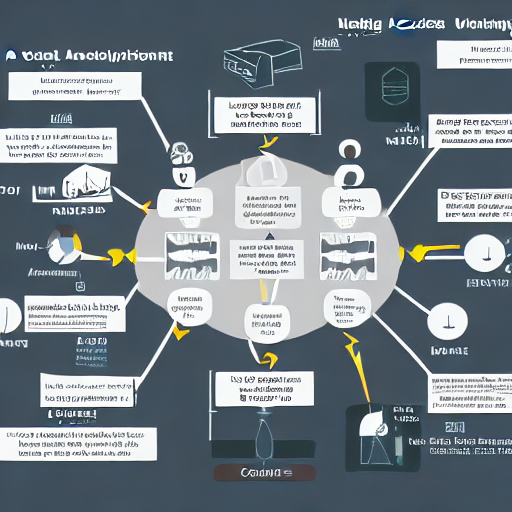

inpaint_edit.png


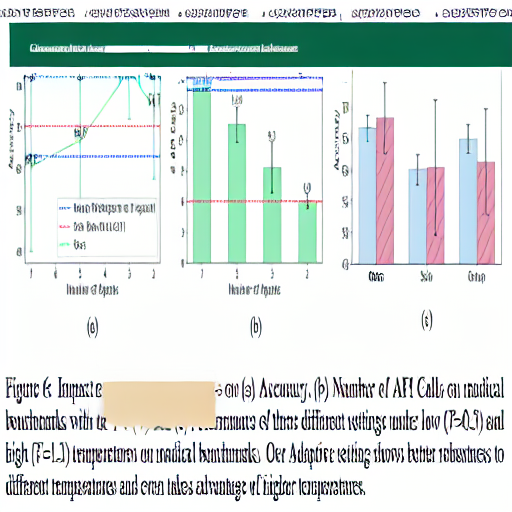

lora_out_0.png


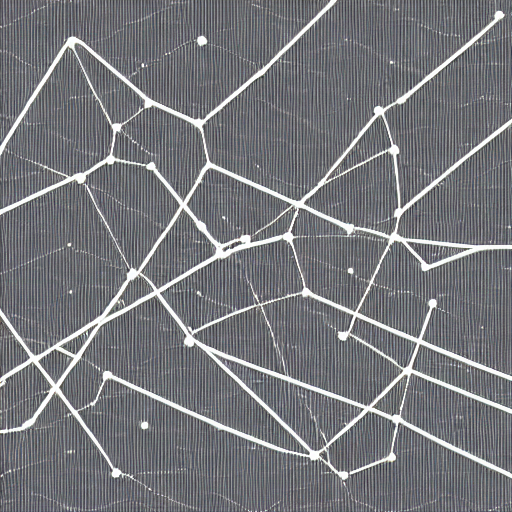

lora_out_1.png


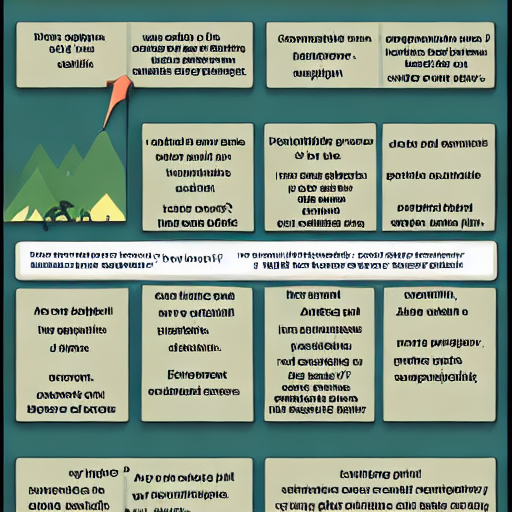

txt2img_0.png


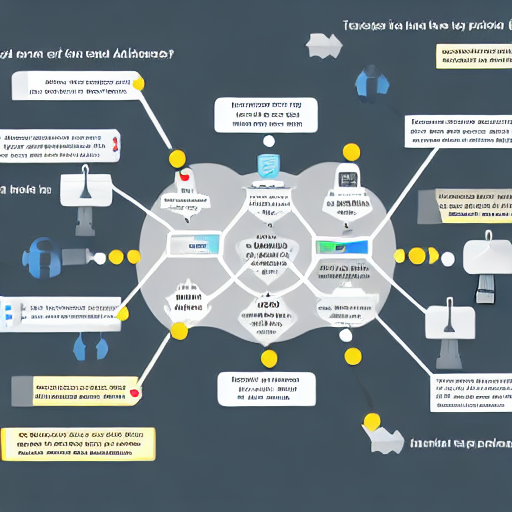

txt2img_1.png


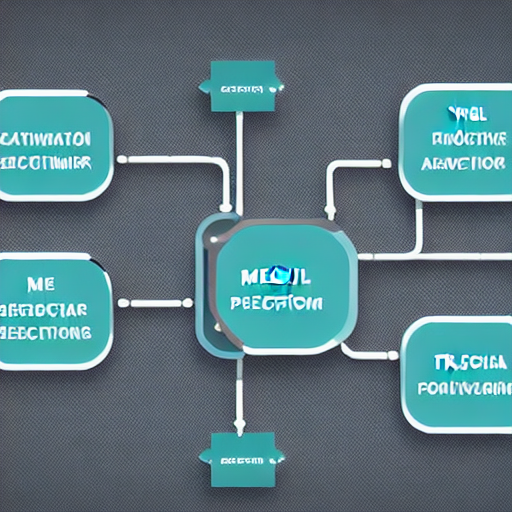

txt2img_2.png


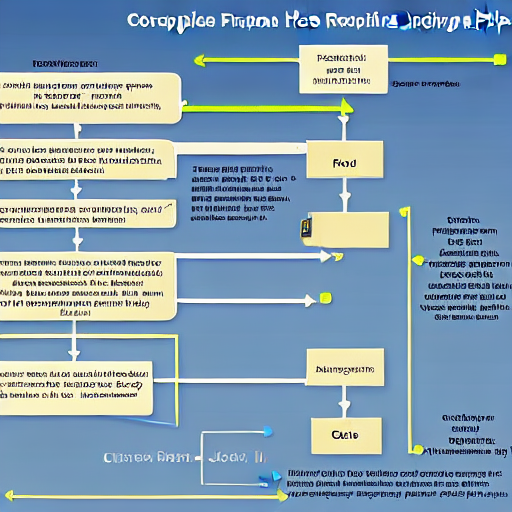


Metrics JSON:
{
  "model_id": "runwayml/stable-diffusion-v1-5",
  "device": "cuda",
  "height": 512,
  "width": 512,
  "num_inference_steps": 25,
  "guidance_scale": 7.5,
  "runs": [
    {
      "type": "txt2img",
      "prompt": "academic-style schematic diagram of a multi-agent AI diplomacy system, agents negotiating on a map, clean vector infographic, minimal color palette",
      "seed": 42,
      "latency_s": 7.141,
      "path": "/content/outputs_sd/txt2img_0.png"
    },
    {
      "type": "txt2img",
      "prompt": "flat vector infographic of a medical multi-agent decision framework with moderator, recruiter, MDT, ICT, arrows and labeled roles, teal and gray theme",
      "seed": 123,
      "latency_s": 4.873,
      "path": "/content/outputs_sd/txt2img_1.png"
    },
    {
      "type": "txt2img",
      "prompt": "conceptual flowchart of a multi-agent RAG pipeline with retrieval, planner, tool calls, and verification, minimalist journal figure",
      "seed": 2025,
      "laten

In [10]:
# Preview all artifacts
from IPython.display import display
from PIL import Image
import json, glob, os

for p in sorted(glob.glob("/content/outputs_sd/*.png")):
    print(os.path.basename(p))
    display(Image.open(p))

print("\nMetrics JSON:")
print(json.dumps(json.load(open("/content/outputs_sd/generation_metrics.json")), indent=2)[:2000], "...")


In [11]:
# Zip everything for submission
import shutil
zip_path = shutil.make_archive("week7_trackA_outputs", "zip", "/content/outputs_sd")
zip_path


'/content/week7_trackA_outputs.zip'

In [13]:
# FastAPI /generate + Cloudflare tunnel public URL

import subprocess, re, time, sys
from pathlib import Path

api_code = r"""
from fastapi import FastAPI
from pydantic import BaseModel
from typing import Optional
import torch, base64, io
from PIL import Image
from diffusers import StableDiffusionPipeline

app = FastAPI(title="Week7 Track1 Stable Diffusion API")

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype  = torch.float16 if device=="cuda" else torch.float32
pipe   = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=dtype).to(device)

class GenRequest(BaseModel):
    prompt: str
    negative_prompt: Optional[str] = "nsfw, watermark, logo"
    steps: int = 20
    guidance: float = 7.0
    height: int = 512
    width: int = 512
    seed: Optional[int] = 123

@app.post("/generate")
def generate(req: GenRequest):
    g = torch.Generator(device=device).manual_seed(req.seed if req.seed is not None else 123)
    img = pipe(
        prompt=req.prompt,
        negative_prompt=req.negative_prompt,
        num_inference_steps=req.steps,
        guidance_scale=req.guidance,
        height=req.height,
        width=req.width,
        generator=g
    ).images[0]
    buf = io.BytesIO()
    img.save(buf, format="PNG")
    b64 = base64.b64encode(buf.getvalue()).decode("utf-8")
    return {"image_base64": b64, "model":"runwayml/stable-diffusion-v1-5"}
"""

Path("/content/backend").mkdir(parents=True, exist_ok=True)
Path("/content/backend/main.py").write_text(api_code)

# Start FastAPI
api_proc = subprocess.Popen(
    ["python","-m","uvicorn","backend.main:app","--host","0.0.0.0","--port","8000"],
    stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True
)

# Expose via Cloudflare tunnel (binary already installed above)
tunnel_proc = subprocess.Popen(
    ["cloudflared","tunnel","--url","http://localhost:8000","--no-autoupdate","--metrics","localhost:40719"],
    stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True
)

# Read public URL from logs
public_url = None
t0 = time.time()
while time.time() - t0 < 30:
    line = tunnel_proc.stdout.readline()
    if not line:
        time.sleep(0.2); continue
    m = re.search(r"(https://[-a-z0-9]+\.trycloudflare\.com)", line)
    if m:
        public_url = m.group(1)
        break

print("Public URL:", public_url or "Check cell output logs to copy the URL.")
print("Swagger docs:", (public_url + "/docs") if public_url else "N/A")


Public URL: https://href-sound-automobiles-photo.trycloudflare.com
Swagger docs: https://href-sound-automobiles-photo.trycloudflare.com/docs
